In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

from verstack import NaNImputer
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [5]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils import save_dataframe


## Data Quering and Loading

In [6]:
# DB related imports
from database.db_utils import init_db
from config.config_loader import load_config
from database.queries import prepped_data_query
from sqlalchemy import text

# Initialize local PostgreSQL session
Session = init_db(load_config("DB_URL"))
session = Session()

# Execute and fetch results
data = session.execute(text(prepped_data_query))

# Close the DB session
session.close()

# Convert to DataFrame
data = pd.DataFrame(data.fetchall(), columns=data.keys())

# Saving cleaned dataset for future use
save_dataframe(data, "00_base_data.csv")

✅ Data successfully saved to ./data\00_base_data.csv with separator ','


In [7]:
# Load dataset
data = pd.read_csv("./data/00_base_data.csv")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    6995 non-null   object 
 1   release_date             6995 non-null   object 
 2   tmdb_vote_count          6995 non-null   int64  
 3   tmdb_vote_average        6995 non-null   float64
 4   genre_names              6995 non-null   object 
 5   budget                   4544 non-null   float64
 6   revenue                  5004 non-null   float64
 7   runtime_in_min           6993 non-null   float64
 8   tmdb_popularity          6995 non-null   float64
 9   production_company_name  6968 non-null   object 
 10  production_country_name  6990 non-null   object 
 11  spoken_languages         6992 non-null   object 
 12  director                 6992 non-null   object 
 13  writer                   6938 non-null   object 
 14  actors                  

In [9]:
# Count missing values
data.isnull().sum()

title                         0
release_date                  0
tmdb_vote_count               0
tmdb_vote_average             0
genre_names                   0
budget                     2451
revenue                    1991
runtime_in_min                2
tmdb_popularity               0
production_company_name      27
production_country_name       5
spoken_languages              3
director                      3
writer                       57
actors                        8
imdb_rating                   9
imdb_votes                    7
metascore                  1657
age_rating                  468
awards                     1112
rotten_tomatoes_rating     1063
meta_critic_rating         1657
dtype: int64

## Exploration of missing data

I have gotten to know this data during the collection process but there are a few aspects I'd like to look into in more detail. Unfortunately, there seems to be quite a bit of missing data, especially in the `budget` and `revenue` columns which I intend to be my main prediction targets when training models. It is not a huge surprise, however, since companies tend to be quite guarded around the financial data of their projects. I will be looking into other sources of financial data in future.

Let's have a look at the total amount of missing data. Hopefully the blanks between the two interect.

In [10]:
# Assuming 'data' is your DataFrame
missing_budget_revenue_count = data[data['budget'].isna() & data['revenue'].isna()].shape[0]
missing_budget_count = data['budget'].isna().sum() - missing_budget_revenue_count
missing_revenue_count = data['revenue'].isna().sum() - missing_budget_revenue_count

# Calculate the total number of rows with missing values in either 'budget' or 'revenue'
total_missing_count = missing_budget_count + missing_revenue_count + missing_budget_revenue_count

print(f"- Number of rows where both budget and revenue are missing: {missing_budget_revenue_count}")
print(f"- Number of additional rows where budget is missing: {missing_budget_count}")
print(f"- Number of additional rows where revenue is missing: {missing_revenue_count}")
print(f"Total number of rows with missing values in either budget or revenue: {total_missing_count}")

- Number of rows where both budget and revenue are missing: 1565
- Number of additional rows where budget is missing: 886
- Number of additional rows where revenue is missing: 426
Total number of rows with missing values in either budget or revenue: 2877


There is indeed an unfortunate number of blanks. Most of them intersxect between the two columns but we still end up with about 30-35% of missing between the two so that is something I'll have to work around.

Let's have a look at the amount of rows missing financial data throughout time. I have a sneaking suspicion that it will be more common to not report financial data in more recent years.

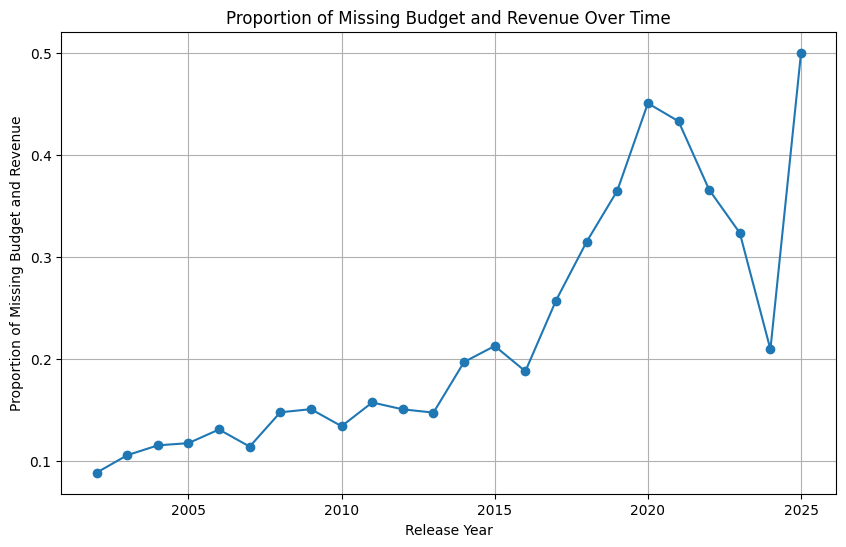

In [11]:
# Assuming 'data' is your DataFrame
plot_data = data.copy()
plot_data['release_date'] = pd.to_datetime(plot_data['release_date'])

# Create a new column to indicate if both budget and revenue are missing
plot_data['missing_budget_revenue'] = plot_data['budget'].isna() & plot_data['revenue'].isna()

# Group by release year and calculate the proportion of missing values
plot_data['release_year'] = plot_data['release_date'].dt.year
missing_by_year = plot_data.groupby('release_year')['missing_budget_revenue'].mean()

# Plot the proportion of missing values over time
plt.figure(figsize=(10, 6))
plt.plot(missing_by_year.index, missing_by_year.values, marker='o', linestyle='-')
plt.xlabel('Release Year')
plt.ylabel('Proportion of Missing Budget and Revenue')
plt.title('Proportion of Missing Budget and Revenue Over Time')
plt.grid(True)
plt.show()

I find it quite interesting that movie financial data has not been reported as frequently in recent years, especially around the COVID-19 pandemic. The movie industry has grown significantly, and so have the costs of producing films. Nowadays, blockbuster movies are often financed through external companies, making financial details a more sensitive topic. During the pandemic, the movie industry contracted, and the quality of movies declined. Consequently, movies have not been performing well financially of late, and companies like Disney may choose not to report this information to protect their stock value.

## Multilable Categorical Features

There are a nuymber of multilable categorical features that will need to be looked into.

In [12]:
def count_unique_values_for_feature(df: pd.DataFrame, feature: str, delimiter: str = ",") -> int:
    """
    Splits the specified feature column by the delimiter and returns the number of unique values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the column to process.
        delimiter (str): The delimiter used to separate multiple values in the column.

    Returns:
        int: The number of unique values.
    """
    return len(df[feature].dropna().str.split(rf"{delimiter}\s*").explode().unique())

# List of features you want to analyze:
features = [
    "genre_names", 
    "production_company_name", "production_country_name", 
            "spoken_languages", "director", "writer", "actors"]

# Create a dictionary with the counts for each feature:
unique_counts = {feature: count_unique_values_for_feature(data, feature) for feature in features}

# Display the results:
for feature, count in unique_counts.items():
    print(f"{feature}: {count} unique values")

genre_names: 19 unique values
production_company_name: 8110 unique values
production_country_name: 98 unique values
spoken_languages: 102 unique values
director: 3753 unique values
writer: 8653 unique values
actors: 8589 unique values


Some of these features contain thousands of unique values, making it impractical to encode them directly. A good approach is to analyze the distribution of observations per category and retain only the most frequent categories. The less frequent categories can be grouped into a single **"Other"** category. This method helps to reduce the dimensionality of the data while preserving the most significant information.

Let's take a look at the distributions per category:

In [13]:
def print_top_categories(df: pd.DataFrame, column: str, top_n: int, delimiter: str = ",", others_label: str = "Others") -> None:
    """
    Prints the top_n unique values from a multi-label column and the total count of values 
    that fall outside the top_n (which would be grouped as 'Others').

    Args:
        df (pd.DataFrame): The DataFrame containing your data.
        column (str): The name of the multi-label column.
        top_n (int): The number of top categories to display.
        delimiter (str): The delimiter separating multiple values (default is a comma).
        others_label (str): The label used for less frequent values.
    """
    # Split the column into individual values and count frequencies
    exploded = df[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    
    # Get the top N categories and the sum for the rest
    top_categories = counts.head(top_n)
    others_count = counts[counts.index.difference(top_categories.index)].sum()
    
    print("--------------------------------------------------||")
    print(f"Top {top_n} unique values for '{column}':")
    print(top_categories)
    print(f"Total count of all other values (will be grouped as '{others_label}'): {others_count}")
    print("--------------------------------------------------||\n")


top_values = {
    "genre_names": 20,
    "production_company_name": 20,
    "production_country_name": 10,
    "spoken_languages": 10,
    "director": 20,
    "writer": 20,
    "actors": 20
}

for feature, top_n in top_values.items():
    print_top_categories(data, feature, top_n)

--------------------------------------------------||
Top 20 unique values for 'genre_names':
genre_names
Drama              3070
Comedy             2462
Thriller           1952
Action             1671
Adventure          1155
Romance            1112
Horror             1059
Crime               972
Science Fiction     847
Family              803
Fantasy             792
Animation           694
Mystery             662
History             354
Music               200
War                 188
Documentary         129
TV Movie             96
Western              68
Name: count, dtype: int64
Total count of all other values (will be grouped as 'Others'): 0
--------------------------------------------------||

--------------------------------------------------||
Top 20 unique values for 'production_company_name':
production_company_name
Universal Pictures       308
Warner Bros. Pictures    275
Columbia Pictures        252
Paramount Pictures       200
Lionsgate                197
20th Century Fox    

- `genre_names`: Will be kept as is since the number of unique categories is perfectly manageable.
- `production_company_name`: Has a relatively even distribution, making it more useful for specific company investigations rather than model training. Therefore, it will be discarded for model training.
- `production_country_name`: Most values are concentrated in the US and the UK, making it a great candidate for consolidating less frequent categories into an "Other" category.
- `spoken_languages`: Another candidate for consolidation, potentially grouping into the top 5 most common languages.
- `director`: Similar to `production_company_name`, it has a wide distribution and will be discarded for model training.

## Preprocessing Pipeline

For this project, I would like to make extensive use of the pipeline functionality in SciKit-Learn to re-familiarize myself with the tool. I will also be making use of `FunctionTransformer` to have custom steps be part of the final pipeline.

### NaNImputer from verstack

The `NaNImputer` from the `verstack` library is a tool designed to handle missing values in a DataFrame. It provides various strategies for imputing missing values, including simple statistical methods and more advanced techniques. It automates the entire process and makes decisions on its own about the best approach for each column.

Due to the nature of the data, each observation in columns like `budget`, `revenue`, and the various critic scores are very individual, and imputation strategies like **median** and **mean** will not be appropriate options. Therefore, I want to make use of machine learning algorithms. `NaNImputer` will make use of `IterativeImputer` for such values, making it a more robust option.

In [14]:
# Define a function to add missing indicators for certain columns.
def impute_data(df: pd.DataFrame, colums_to_exclude: list = None) -> pd.DataFrame:
    if colums_to_exclude:
        df = df.drop(columns=colums_to_exclude).copy()
    else:
        df.copy()
    imputer = NaNImputer()
    df = imputer.impute(df)
    return df

imputation_transformer = FunctionTransformer(impute_data, validate=False)

#### Data Types cionversion transformers

Some features need to be reformatted and below functions will deal with that.

In [15]:
# Some columns need to get converted to numeric
def convert_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        # Convert to string, remove commas, then convert to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    return df

to_numeric = FunctionTransformer(convert_to_numeric, validate=False)

#### Missing indicator features
I want to set up binary features for the columns where I have a large number of blanks to be able to investigate the imputed data later on.

In [16]:
# Define a function to add missing indicators for certain columns.
def add_missing_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        df[col + "_missing"] = df[col].isnull().astype(int)
    return df

missing_indicator_transformer = FunctionTransformer(add_missing_indicators, validate=False)

# iter_cols = ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']

### Feature Engineering

#### Award features
The `awards` column can be used to extract various columns for BAFTAs, Oscars and total awards and nominations.

In [17]:
def extract_awards_info(awards_str):
    """
    Extracts numerical awards information from a text string.

    Parameters
    ----------
    awards_str : str
        The awards description string.

    Returns
    -------
    pd.Series
        A Series with the following index:
        ["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"]
    """
    # Handle missing or "N/A" values.
    if pd.isna(awards_str) or awards_str.strip() in ["N/A", ""]:
        return pd.Series([0, 0, 0, 0, 0, 0],
                         index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])
    
    # Extract overall totals.
    # Look for a pattern like "56 wins" (we use negative lookahead to avoid picking up Oscar wins)
    total_wins_match = re.search(r'(\d+)\s+wins?(?!.*Oscars)', awards_str, flags=re.IGNORECASE)
    total_noms_match = re.search(r'(\d+)\s+nominations', awards_str, flags=re.IGNORECASE)
    total_wins = int(total_wins_match.group(1)) if total_wins_match else 0
    total_noms = int(total_noms_match.group(1)) if total_noms_match else 0

    # Oscar-specific extraction:
    oscar_noms_match = re.search(r'Nominated for\s+(\d+)\s+Oscars?', awards_str, flags=re.IGNORECASE)
    oscar_noms = int(oscar_noms_match.group(1)) if oscar_noms_match else 0
    # Look for something like "Oscars. 56 wins" or "Oscars 56 wins" (using non-digit separator)
    oscar_wins_match = re.search(r'Oscars?[\W_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    oscar_wins = int(oscar_wins_match.group(1)) if oscar_wins_match else 0

    # BAFTA-specific extraction:
    # For nominations, sometimes the text might run together (e.g. "BAFTA Award28 nominations total")
    bafta_noms_match = re.search(r'Nominated for\s+(\d+)\s*BAFTA', awards_str, flags=re.IGNORECASE)
    bafta_noms = int(bafta_noms_match.group(1)) if bafta_noms_match else 0
    # For wins, allow an optional "Award" word after BAFTA.
    bafta_wins_match = re.search(r'BAFTA(?:\s+Award)?[\D_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    bafta_wins = int(bafta_wins_match.group(1)) if bafta_wins_match else 0

    return pd.Series([total_wins, total_noms, oscar_wins, oscar_noms, bafta_wins, bafta_noms],
                     index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])


def transform_awards(X):
    """
    Expects X to be a DataFrame with a single column (e.g., 'awards').
    Applies extract_awards_info row-wise and returns a DataFrame.
    """
    # Apply the function to the first (and only) column
    return X.iloc[:, 0].apply(extract_awards_info)

# Wrap the function in a FunctionTransformer
awards_transformer = FunctionTransformer(transform_awards, validate=False)

#### Multi-lable categorical features adjustment

Below ``FunctionTransformer`` will group the given multi-lable feature into a top N + Others categories.

In [18]:
def transform_top_categories(X, column, top_n, delimiter=",", others_label="Others"):
    """
    Transforms a multi-label column by keeping only the top_n categories (based on frequency)
    and replacing all other categories with a generic label.
    
    Parameters:
        X (pd.DataFrame): Input DataFrame.
        column (str): The name of the multi-label column to process.
        top_n (int): Number of top categories to keep.
        delimiter (str): Delimiter separating the values.
        others_label (str): Label to assign to categories not among the top_n.
    
    Returns:
        pd.DataFrame: A DataFrame with one column (the processed column).
    """
    X = X.copy()
    # Split the column values, explode, and count frequencies.
    exploded = X[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    top_categories = counts.head(top_n).index.tolist()
    
    def map_categories(cell):
        if pd.isna(cell):
            return cell
        # Split and strip each value.
        cats = [cat.strip() for cat in cell.split(delimiter)]
        # Replace values not in top_categories with others_label.
        new_cats = [cat if cat in top_categories else others_label for cat in cats]
        # Remove duplicates while preserving order.
        seen = set()
        new_cats = [x for x in new_cats if x not in seen and not seen.add(x)]
        return delimiter.join(new_cats)
    
    X[column] = X[column].apply(map_categories)
    # Return a DataFrame with just the transformed column.
    return X[[column]]

# Now, to create a FunctionTransformer for, say, the 'production_country_name' column with top_n=5:
transformer_prod_country = FunctionTransformer(
    func=partial(transform_top_categories, column="production_country_name", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

# Similarly, for 'spoken_languages' column with top_n=5:
transformer_spoken_lang = FunctionTransformer(
    func=partial(transform_top_categories, column="spoken_languages", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

#### Release date rework

`release_date` can be split int oseparate integer columns to be used during training later but binary features like `is_weekend` and `is_holiday` can also be derived.

In [19]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['is_weekend'] = (df['release_date'].dt.weekday >= 4).astype(int)
    df['is_holiday_season'] = df['release_month'].isin([6, 7, 11, 12]).astype(int)
    df['movie_age'] = 2025 - df['release_year']
    return df

# Wrap the function as a transformer
date_features_transformer = FunctionTransformer(add_date_features, validate=False)

#### Return on Investment
Great option for looking into the budget-revenue relationship

In [20]:
def calculate_roi(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['roi'] = (df['revenue'] - df['budget']) / df['budget']
    return df

# Wrap the function as a transformer
roi_transformer = FunctionTransformer(calculate_roi, validate=False)

#### `actors`, `directors` and `writers`

These features are quite valuable I think but they need to be reworked. I do know that IMDB has these ones ordered by importance and billing so we can get the most relevant people in each category.

In [21]:
def extract_actors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['first_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['second_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    df['third_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[2].strip() if pd.notnull(x) and len(x.split(',')) > 2 else None)
    return df.drop(columns=['actors'])

def extract_directors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_director'] = df['director'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_director'] = df['director'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['director'])

def extract_writers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_writer'] = df['writer'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_writer'] = df['writer'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['writer'])

# Create FunctionTransformers
actors_transformer = FunctionTransformer(extract_actors)
directors_transformer = FunctionTransformer(extract_directors)
writers_transformer = FunctionTransformer(extract_writers)

### Main ColumnTransformer
This `ColumnTransformer` will apply the included steps simultaniously. Each step relies on its own set of features so there is no overlap and no chance of issues. `Pipeline` applies the step in order which I will make use of later on.

In [22]:
main_transformer = ColumnTransformer(
    transformers=[
        ('missing_indicator', missing_indicator_transformer, ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 
                                                              'revenue'
                                                              ]),
        ('awards', awards_transformer, ['awards']),
        ('date_feature_engineering', date_features_transformer, ['release_date']),
        ('top_n_prod_country', transformer_prod_country, ['production_country_name']),
        ('top_n_spoken_lang', transformer_spoken_lang, ['spoken_languages']),
        ('actors', actors_transformer, ['actors']),
        ('directors', directors_transformer, ['director']),
        ('writers', writers_transformer, ['writer']),
        ('to_numeric', to_numeric, ['imdb_rating', 'imdb_votes'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False
)

# Set output to pandas dataframe
main_transformer.set_output(transform='pandas')

# Apply the preprocessor to the data
# clean_data = main_transformer.fit_transform(data)
# clean_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('missing_indicator',
                                 FunctionTransformer(func=<function add_missing_indicators at 0x000002B7D8A4E7A0>),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget', 'revenue']),
                                ('awards',
                                 FunctionTransformer(func=<function transform_awards at 0x000002B7D8A4E2A0>),
                                 ['awards']),
                                ('date_feature_engi...
                                 ['actors']),
                                ('directors',
                                 FunctionTransformer(func=<function extract_directors at 0x000002B7D8A4ECA0>),
                                 ['director']),
                                ('writers',
                                 FunctionTransformer(func=<function extract_writers at 0x000002B7D8A4E200>),
                                 ['writer']),
                                ('to_numeric',
                                 FunctionTransformer(func=<function convert_to_numeric at 0x000002B7D8A4DD00>),
                                 ['imdb_rating', 'imdb_votes'])],
                  verbose_feature_names_out=False)

### Pipeline

#### Full data pipeline

The main transformer will be applied so that all the feature transformations and engineering gets applied on actual data and then all the missing data will be imputed. I like this order because it makes sure the generated features are all based on real data. 

I would like to experiment a bit with various inputs of the imputation to study the effects on model performance and prediction. Let's start with running the imputation on all available data simultaniously.

In [23]:
full_pipeline = Pipeline(steps=[
    ('main_transformer', main_transformer),
    ('impute_data', imputation_transformer),
    # ('roi_feature_engineering', roi_transformer),
    # ('dropper', dropper, columns_to_drop)
])

# Set output to pandas dataframe
full_pipeline.set_output(transform='pandas')

Pipeline(steps=[('main_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('missing_indicator',
                                                  FunctionTransformer(func=<function add_missing_indicators at 0x000002B7D8A4E7A0>),
                                                  ['metascore',
                                                   'rotten_tomatoes_rating',
                                                   'meta_critic_rating',
                                                   'budget', 'revenue']),
                                                 ('awards',
                                                  FunctionTransformer(func=<function transform_awards at 0x000002B7D8A4E2...
                                                  FunctionTransformer(func=<function extract_directors at 0x000002B7D8A4ECA0>),
                                                  ['director']),
                                                 ('writers',
                                                  FunctionTransformer(func=<function extract_writers at 0x000002B7D8A4E200>),
                                                  ['writer']),
                                                 ('to_numeric',
                                                  FunctionTransformer(func=<function convert_to_numeric at 0x000002B7D8A4DD00>),
                                                  ['imdb_rating',
                                                   'imdb_votes'])],
                                   verbose_feature_names_out=False)),
                ('impute_data',
                 FunctionTransformer(func=<function impute_data at 0x000002B7D8A4E480>))])

In [33]:
def create_pipeline(colums_to_exclude: list = None):    
    # Define a function to add missing indicators for certain columns.
    def impute_data(df: pd.DataFrame) -> pd.DataFrame:
        df.copy()
        imputer = NaNImputer()
        df = imputer.impute(df)
        return df
    # Initialize imputation transformer
    imputation_transformer = FunctionTransformer(impute_data, validate=False)

    # Missing values flag features
    missing_flag_cols = ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']
    if colums_to_exclude:
        missing_flag_cols = [col for col in missing_flag_cols if col not in colums_to_exclude]
    print(missing_flag_cols)
    # Build main transformer
    main_transformer = ColumnTransformer(
        transformers=[
            ('missing_indicator', missing_indicator_transformer, missing_flag_cols),
            ('awards', awards_transformer, ['awards']),
            ('date_feature_engineering', date_features_transformer, ['release_date']),
            ('top_n_prod_country', transformer_prod_country, ['production_country_name']),
            ('top_n_spoken_lang', transformer_spoken_lang, ['spoken_languages']),
            ('actors', actors_transformer, ['actors']),
            ('directors', directors_transformer, ['director']),
            ('writers', writers_transformer, ['writer']),
            ('to_numeric', to_numeric, ['imdb_rating', 'imdb_votes'])
        ],
        remainder='passthrough', 
        verbose_feature_names_out=False
    )
    # Set output to pandas dataframe
    main_transformer.set_output(transform='pandas')


    # Build pipeline
    pipeline = Pipeline(steps=[
        ('main_transformer', main_transformer),
        ('impute_data', imputation_transformer),
        # ('roi_feature_engineering', roi_transformer),
        # ('dropper', dropper, columns_to_drop)
    ])
    # Set output to pandas dataframe
    pipeline.set_output(transform='pandas')

    return pipeline

In [28]:
full_pipeline = create_pipeline()

['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']


In [197]:
clean_data = full_pipeline.fit_transform(data)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         6995
     .. columns:      42
     .. mb in memory: 2.13
     .. NaN cols num: 19

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 10 cols
     . Imputed (regression) - 1657

In [198]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       6995 non-null   float64       
 1   rotten_tomatoes_rating          6995 non-null   float64       
 2   meta_critic_rating              6995 non-null   float64       
 3   budget                          6995 non-null   float64       
 4   revenue                         6995 non-null   float64       
 5   metascore_missing               6995 non-null   int64         
 6   rotten_tomatoes_rating_missing  6995 non-null   int64         
 7   meta_critic_rating_missing      6995 non-null   int64         
 8   budget_missing                  6995 non-null   int64         
 9   revenue_missing                 6995 non-null   int64         
 10  total_wins                      6995 non-null   int64         
 11  tota

In [199]:
# Saving cleaned dataset for future use
save_dataframe(clean_data, "01_clean_data.csv")

✅ Data successfully saved to ./data\01_clean_data.csv with separator ','


#### No Revenue Pipeline
Let's exclude the target of my predictive modelimg which will be `revenue` to make sure the model cannot gain any information due to the reelations created by the imputation.

In [200]:
no_revenue_imputation_transformer = FunctionTransformer(impute_data, kw_args={'colums_to_exclude': ['revenue']}, validate=False)

no_revenue_pipeline = Pipeline(steps=[
    ('main_transformer', main_transformer),
    ('impute_data', no_revenue_imputation_transformer),
    # ('roi_feature_engineering', roi_transformer),
    # ('dropper', dropper, columns_to_drop)
])

# Set output to pandas dataframe
no_revenue_pipeline.set_output(transform='pandas')

Pipeline(steps=[('main_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('missing_indicator',
                                                  FunctionTransformer(func=<function add_missing_indicators at 0x0000019A6F245800>),
                                                  ['metascore',
                                                   'rotten_tomatoes_rating',
                                                   'meta_critic_rating',
                                                   'budget', 'revenue']),
                                                 ('awards',
                                                  FunctionTransformer(func=<function transform_awards at 0x0000019A6F2451...
                                                  FunctionTransformer(func=<function extract_writers at 0x0000019A07DD0400>),
                                                  ['writer']),
                                                 ('to_numeric',
                                                  FunctionTransformer(func=<function convert_to_numeric at 0x0000019A6F245BC0>),
                                                  ['imdb_rating',
                                                   'imdb_votes'])],
                                   verbose_feature_names_out=False)),
                ('impute_data',
                 FunctionTransformer(func=<function impute_data at 0x0000019A001939C0>,
                                     kw_args={'colums_to_exclude': ['revenue']}))])

In [34]:
no_revenue_pipeline = create_pipeline(['revenue'])

['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget']


In [35]:
no_revenue_data = data.drop(columns=['revenue'])
no_revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    6995 non-null   object 
 1   release_date             6995 non-null   object 
 2   tmdb_vote_count          6995 non-null   int64  
 3   tmdb_vote_average        6995 non-null   float64
 4   genre_names              6995 non-null   object 
 5   budget                   4544 non-null   float64
 6   runtime_in_min           6993 non-null   float64
 7   tmdb_popularity          6995 non-null   float64
 8   production_company_name  6968 non-null   object 
 9   production_country_name  6990 non-null   object 
 10  spoken_languages         6992 non-null   object 
 11  director                 6992 non-null   object 
 12  writer                   6938 non-null   object 
 13  actors                   6987 non-null   object 
 14  imdb_rating             

In [36]:
clean_data_no_revenue = no_revenue_pipeline.fit_transform(no_revenue_data)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         6995
     .. columns:      40
     .. mb in memory: 2.03
     .. NaN cols num: 18

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 9 cols
     . Imputed (regression) - 1657 

In [ ]:
clean_data_no_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       6995 non-null   float64       
 1   rotten_tomatoes_rating          6995 non-null   float64       
 2   meta_critic_rating              6995 non-null   float64       
 3   budget                          6995 non-null   float64       
 4   revenue                         6995 non-null   float64       
 5   metascore_missing               6995 non-null   int64         
 6   rotten_tomatoes_rating_missing  6995 non-null   int64         
 7   meta_critic_rating_missing      6995 non-null   int64         
 8   budget_missing                  6995 non-null   int64         
 9   revenue_missing                 6995 non-null   int64         
 10  total_wins                      6995 non-null   int64         
 11  tota

In [ ]:
clean_data_no_revenue['revenue'] = data['revenue']
# Saving cleaned dataset for future use
save_dataframe(clean_data_no_revenue, "1.1_clean_data_no_revenue.csv")

✅ Data successfully saved to ./data\1.1_clean_data_no_revenue.csv with separator ','


In [ ]:
target = 'revenue'
X = data.drop(target, axis=1)
y = data[target]

,metascore,rotten_tomatoes_rating,meta_critic_rating,budget,revenue,metascore_missing,rotten_tomatoes_rating_missing,meta_critic_rating_missing,budget_missing,revenue_missing,...,imdb_rating,imdb_votes,title,tmdb_vote_count,tmdb_vote_average,genre_names,runtime_in_min,tmdb_popularity,production_company_name,age_rating
0,12.186938,32.000000,12.116073,1.937799e+07,7.113382e+06,1,0,1,1,1,...,5.1,10297.0,Carter,378,6.000,"Action, Thriller, Crime",132.0,27.043,Apeitda,TV-MA
1,13.206222,92.500654,13.310836,9.358694e+06,7.546961e+06,1,1,1,1,1,...,7.3,17277.0,The Shadow in My Eye,494,7.829,"War, Drama, History",107.0,16.008,Miso Film,TV-MA
2,48.000000,56.000000,48.000000,1.165047e+07,4.798124e+06,0,0,0,1,1,...,6.3,28616.0,Noelle,673,6.595,"Family, Comedy, Fantasy",100.0,10.040,Walt Disney Pictures,G
3,12.733443,70.849551,12.691501,9.444139e+06,4.173229e+06,1,1,1,1,1,...,7.2,1755.0,Play,349,7.278,Comedy,108.0,5.214,"Chapter 2, Moonshaker",TV-MA
4,12.710978,42.000000,12.608110,5.753416e+06,4.476653e+06,1,0,1,1,1,...,8.3,28457.0,Dave Chappelle: Sticks & Stones,320,7.600,Comedy,65.0,7.683,Missing_data,TV-MA


In [ ]:
clean_data = full_pipeline.fit_transform(X, y)

In [ ]:
# clean_data["revenue"] = y

In [ ]:
# Saving cleaned dataset for future use
save_dataframe(clean_data, "01_clean_data.csv")

✅ Data successfully saved to ./data\01_clean_data.csv with separator ','
